In [21]:
import numpy as np
import matplotlib.pyplot as plt
from py import DiscClass
from galpy.potential import toVerticalPotential, IsothermalDiskPotential, turn_physical_off
FilePath= '/epsen_data/scr/bennett/Sgr-VerticalWaves/'
import pickle 
import galpy
from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=16.,xtick_labelsize=14.,ytick_labelsize=14.)
from py import misc
from galpy.util.bovy_conversion import dens_in_msolpc3
import astropy.units as apu
from scipy.interpolate import interp1d

import importlib
importlib.reload(DiscClass)

<module 'py.DiscClass' from '/epsen_data/scr/bennett/Sgr-VerticalWaves/py/DiscClass.py'>

In [2]:
alpha= [0.01,0.2,0.5,0.8,1.0]
alpha_str= ['001','02','05','08','10']
nbins= 201

mid= np.zeros([len(alpha),201])
p= np.zeros([len(alpha),201,2001])
padj= np.zeros([len(alpha),201,2001])
padjerr= np.zeros([len(alpha),201,2001])
err= np.zeros([len(alpha),201,2001])
v= np.zeros([len(alpha),201,2001])
zsun= np.zeros([len(alpha),2001])

for i,a in enumerate(alpha_str):
    midfile= FilePath+'data/1DSimData/1e6/mid_'+str(nbins)+'_'+a+'.dat'
    pfile= FilePath+'data/1DSimData/1e6/rho_'+str(nbins)+'_'+a+'.dat'
    padjfile= FilePath+'data/1DSimData/1e6/rho_adj_'+str(nbins)+'_'+a+'.dat'
    padjerrfile= FilePath+'data/1DSimData/1e6/rho_adj_err_'+str(nbins)+'_'+a+'.dat'
    errfile= FilePath+'data/1DSimData/1e6/rho_err_'+str(nbins)+'_'+a+'.dat'
    vfile= FilePath+'data/1DSimData/1e6/v_'+str(nbins)+'_'+a+'.dat'
    zsfile= FilePath+'data/1DSimData/1e6/zsun_'+str(nbins)+'_'+a+'.dat'
    with open(midfile) as mf, open(pfile) as pf, open(padjfile) as paf, open(padjerrfile) as paef, open(errfile) as ef, open(vfile) as vf,\
         open(zsfile) as zf:
        mid[i]= np.loadtxt(mf)
        p[i]= np.loadtxt(pf)
        padj[i]= np.loadtxt(paf)
        padjerr[i]= np.loadtxt(paef)
        err[i]= np.loadtxt(ef)
        v[i]= np.loadtxt(vf)
        zsun[i]= np.loadtxt(zf)

In [10]:
with open(FilePath+'data/Orbits/ModelOrbits/MW1_SGR1_1apo',"rb") as f:
    o_sgr = pickle.load(f)
    
MLU,MVU,MTU,MMU,MDU,MSDU= misc.get_units(o_sgr)

TwoPiG= 0.0270319483 #pc*(km/s)^2/Msun  Set TwopiG to 1
SMPDU= 78.9 #Msun/pc^2  Set the total sufrace density of the slab to 1
SVU= 20.5 # km/s  Set the velocity dispersion to 1
SLU= 1./(TwoPiG*SMPDU/SVU**2)/1000. # kpc
SDU= SMPDU/SLU
STU= (SLU/SVU)*(1.*apu.kpc/apu.km*apu.s).to(apu.Myr).value
SMU= SLU*1000.*SVU**2/TwoPiG# Make this exact
SSDU= SMU/(SLU*1000)**2 # Surface Density units

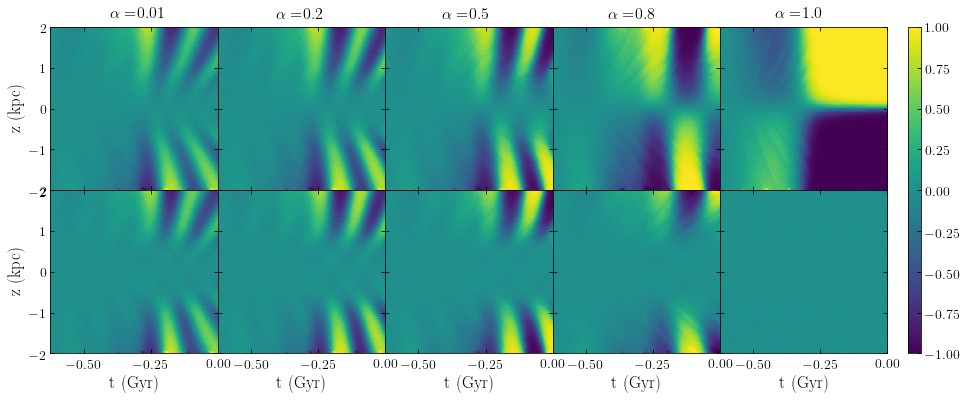

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

A= [(pp-pp[::-1])/(pp+pp[::-1]) for pp in p]
Aadj= [(pp-pp[::-1])/(pp+pp[::-1]) for pp in padj]

fig,ax= plt.subplots(2,5,sharey=True,sharex=True,figsize=[15,6])#,constrained_layout=True)

a_nicestr= [r'$0.01$',r'$0.2$',r'$0.5$',r'$0.8$',r'$1.0$']

for i,a in enumerate(A):
    plt.text(0.62*i-2.9,6.2,r'$\mathrm{\alpha=}$'+a_nicestr[i])
    im= ax[0,i].imshow(a,aspect='auto',vmin=-1.,vmax=1.,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
    im= ax[1,i].imshow(Aadj[i],aspect='auto',vmin=-1.,vmax=1.,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
    ax[0,0].set_ylabel(r'$\mathrm{z\,\,(kpc)}$')
    ax[1,0].set_ylabel(r'$\mathrm{z\,\,(kpc)}$')
    ax[1,i].set_xlabel(r'$\mathrm{t\,\,(Gyr)}$')
    
fig.colorbar(im, ax=ax.flat, aspect=25, anchor=(1.3,1.))

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(FilePath+'plots/alphasim.pdf',bbox_inches='tight')

In [5]:
p_mid= 0.1/dens_in_msolpc3(MVU,MLU)
mwd= IsothermalDiskPotential(p_mid,20.5/MVU,ro=MLU,vo=MVU)

In [6]:
disc= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o_sgr.t,zpt=100,vpt=50)

In [7]:
StlrI= 1

with open(FilePath+'data/SgrModel/halo_masses.dat','rb') as f:
    halo_m= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/halo_radius.dat','rb') as f:
    halo_a= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/stlr_masses.dat','rb') as f:
    stlr_m= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/stlr_radius.dat','rb') as f:
    stlr_a= np.loadtxt(f)[StlrI]
    
halo_pot= galpy.potential.HernquistPotential(amp=2.*halo_m*apu.M_sun,a=halo_a*apu.kpc,ro=MLU,vo=MVU) 
stlr_pot= galpy.potential.HernquistPotential(amp=2.*stlr_m*apu.M_sun,a=halo_a*apu.kpc,ro=MLU,vo=MVU) 

sgr_pot= halo_pot+stlr_pot
turn_physical_off(sgr_pot)

In [8]:
disc.add_satellite(satpot=sgr_pot,sat=o_sgr,df_prop=[[p_mid],[20.5/MVU]],ftype='rotate',
                   tdep=True,method='slowest',zsun='fit')

100%|██████████| 100/100 [1:08:37<00:00, 41.17s/it]


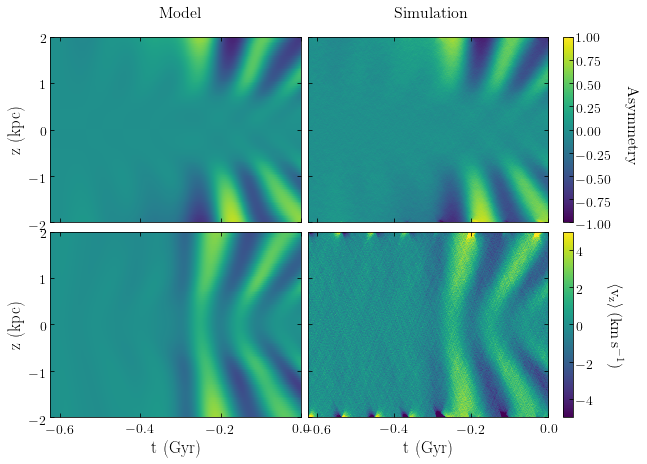

In [33]:
Anew=np.array([(A[0][i]+A[0][i+1]+A[0][i+2]+A[0][i+3])/4. for i in range(0,200,4)])
Vnew=np.array([(v[0][i]+v[0][i+1])/2. for i in range(0,200,2)])
pnew=np.array([(p[0][i]+p[0][i+1])/2. for i in range(0,200,2)])

gridspec = {'width_ratios': [1, 1.2]}
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,7),gridspec_kw=gridspec)

ax1.imshow(np.vstack([-disc.A.T[::-1],disc.A.T]),aspect='auto',vmin=-1,vmax=1,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
im2= ax2.imshow(Aadj[0],aspect='auto',vmin=-1,vmax=1,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
plt.colorbar(im2, ax=ax2)
ax3.imshow(disc.meanV*MVU,aspect='auto',vmin=-5,vmax=5,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
im4= ax4.imshow(v[0]/p[0]*SVU,aspect='auto',vmin=-5,vmax=5,extent=[o_sgr.t[-1]*MTU/1000.,0,-2,2])
plt.colorbar(im4,ax=ax4)
plt.text(-1.01,6.6,r'$\mathrm{Model}$')
plt.text(-0.40,6.6,r'$\mathrm{Simulation}$')
plt.text(0.2,4.9,r'$\mathrm{Asymmetry}$',rotation=-90)
plt.text(0.15,0.6,r'$\mathrm{\langle v_z\rangle\,(km\,s^{-1})}$',rotation=-90)

ax1.set_ylabel(r'$\mathrm{z\,\,(kpc)}$')
ax3.set_ylabel(r'$\mathrm{z\,\,(kpc)}$')
ax3.set_xlabel(r'$\mathrm{t\,\,(Gyr)}$')
ax4.set_xlabel(r'$\mathrm{t\,\,(Gyr)}$')

plt.subplots_adjust(wspace=0.025, hspace=0.05)

plt.savefig(FilePath+'plots/modelvssimAV.pdf',bbox_inches='tight')

In [22]:
indx=-1

Aerr=np.empty([5,201])
Alow=np.empty([5,67])
Ahigh=np.empty([5,67])

for i in range(len(alpha)):
    Aerr[i]= np.sqrt((2*padj[i,:,-1]/(padj[i,:,-1]+padj[i,:,-1][::-1])**2)**2*padjerr[i,:,-1][::-1]+
                     (2*padj[i,:,-1][::-1]/(padj[i,:,-1]+padj[i,:,-1][::-1])**2)**2*padjerr[i,:,-1])
    Alow[i]= np.array([np.min(Aadj[i][j,-1]-Aerr[i][j+2]) for j in range(0,201,3)])
    Ahigh[i]= np.array([np.max(Aadj[i][j,-1]+Aerr[i][j+2]) for j in range(0,201,3)])

Acompare=np.empty((201,2001))
for i in range(2001):
    gridA= interp1d(np.append(-disc.zA[i,::-1],disc.zA[i])*MLU,
                    np.append(-disc.A[i,::-1],disc.A[i]),
                    fill_value='extrapolate',kind='cubic')
    Acompare[:,i]= gridA(mid[0])

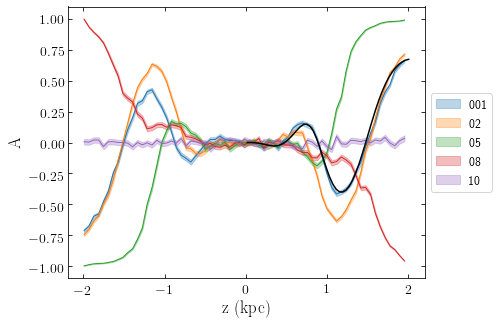

In [24]:
fig= plt.figure(figsize=(8,5))
ax = plt.subplot(111)

colours=['C0','C1','C2','C3','C4','C4']

for i in range(len(alpha)):
    ax.fill_between(mid[i][:-1:3], Alow[i], Ahigh[i],color=colours[i], alpha=0.3,label=alpha_str[i])
    ax.plot(mid[i][::3],Aadj[i][::3,-1],c=colours[i],lw=1)

ax.plot(disc.zA[-1]*MLU,disc.A[-1],'k')
ax.set_xlabel(r'$\mathrm{z\,\,(kpc)}$')
ax.set_ylabel(r'$\mathrm{A}$')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [32]:
for i in range(5):
    print('alpha = ',alpha[i])
    print('Median |z|<0.5: ',np.median(np.abs(Acompare[np.abs(mid[i])<0.5]-Aadj[i][np.abs(mid[i])<0.5])))
    print('Percentage |z|<0.5: ',np.sum(np.abs((Acompare[np.abs(mid[i])<0.5]-
                                                Aadj[i][np.abs(mid[i])<0.5]))>0.07)/201/2001*100)
    print('Median 0.5<|z|<1.9: ',np.median(np.abs(Acompare[(np.abs(mid[i])>0.5)*(np.abs(mid[i])<1.9)]-
                                                  Aadj[i][(np.abs(mid[i])>0.5)*(np.abs(mid[i])<1.9)])))
    print('Percentage 0.5<|z|<1.9: ',np.sum(np.abs((Acompare[(np.abs(mid[i])>0.5)*(np.abs(mid[i])<1.9)]-
                                                    Aadj[i][(np.abs(mid[i])>0.5)*(np.abs(mid[i])<1.9)]))>0.07)/200/2001*100)
    print()

alpha =  0.01
Median |z|<0.5:  0.012163187696459087
Percentage |z|<0.5:  0.003978110447263931
Median 0.5<|z|<1.9:  0.018602696220728236
Percentage 0.5<|z|<1.9:  1.9865067466266866

alpha =  0.2
Median |z|<0.5:  0.013048148922740949
Percentage |z|<0.5:  0.03381393880174341
Median 0.5<|z|<1.9:  0.02855968018361643
Percentage 0.5<|z|<1.9:  19.315842078960518

alpha =  0.5
Median |z|<0.5:  0.014779920861854349
Percentage |z|<0.5:  0.33465854137607814
Median 0.5<|z|<1.9:  0.0463764718940656
Percentage 0.5<|z|<1.9:  27.93503248375812

alpha =  0.8
Median |z|<0.5:  0.014138981864832121
Percentage |z|<0.5:  0.08005947275118659
Median 0.5<|z|<1.9:  0.046227096455034034
Percentage 0.5<|z|<1.9:  28.009495252373817

alpha =  1.0
Median |z|<0.5:  0.013757841295010696
Percentage |z|<0.5:  0.07757315372164664
Median 0.5<|z|<1.9:  0.05585663277061397
Percentage 0.5<|z|<1.9:  31.88205897051474

